<a href="https://colab.research.google.com/github/azrielrisywan/team-assignment-2-ai-binus/blob/master/cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Table of Contents**

1. Introduction
1. Import library
1. Fetch datasets from kaggle
1. Prepare training data
1. Data pre-processing
1. Model building
1. Prepare testing data
1. Find prediction



# **Introduction**

In this project, we'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats but our computer will find it a bit more difficult.
### Data Description
The folder "train" contains two sub-folders "cats" & "dogs" which contain images of cats and dogs respectively.The folder "test1" contain unknown images which we have to classify.
### Data
To download the Dataset click [here](https://www.kaggle.com/c/dogs-vs-cats/data)
### Objective
To build a deep learning classification model which classify whether images contain either a dog or a cat.



# Tambah dependency untuk hyperparameter tuning

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [11]:
!pip install kaggle

# **1. Import Library**

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img  # Perbarui impor
from tensorflow.keras.utils import to_categorical  # Perbarui impor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt  # Untuk hyperparameter tuning

# **2. Fetch datasets from kaggle**

In [24]:
# Step-1: create .kaggle directory
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [26]:
# Step-2: create a API token in your kaggle account.Upload this token("kaggle.json") on any folder here.move this file into ~/.kaggle.
# Below code is for moving ".json" file
!mv /content/sample_data/kaggle.json ~/.kaggle/kaggle.json

In [27]:
# Step-3: give authorization to KaggleApi
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [28]:
!chmod 600 ~/.kaggle/kaggle.json

In [41]:
# Step-4: Download datasets from kaggle using API
!kaggle competitions download -c dogs-vs-cats

In [44]:
# unzip the dataset
from zipfile import ZipFile
zf = ZipFile('/content/sample_data/train.zip')
zf.extractall('/content/sample_data/train') #save files in selected folder
zf.close()

# **3. Prepare Training Data**
Here we will create dataframe which will store all file names in "filenames" column and value "1" for "dog" and "0" for "cat".

In [55]:
filenames = os.listdir("/content/sample_data/train/train")
categories = []
for name in filenames:
    category = name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

image_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [56]:
# See top 5 rows of the dataset
image_df.head()

,filename,category
0,cat.1556.jpg,0
1,cat.6536.jpg,0
2,cat.5894.jpg,0
3,dog.10399.jpg,1
4,cat.1755.jpg,0


In [57]:
# See buttom 5 cell of the dataset
image_df.tail()

,filename,category
24995,dog.5.jpg,1
24996,cat.1451.jpg,0
24997,cat.12038.jpg,0
24998,dog.7546.jpg,1
24999,cat.1307.jpg,0


In [58]:
image_df.shape

(25000, 2)

<Axes: xlabel='category'>

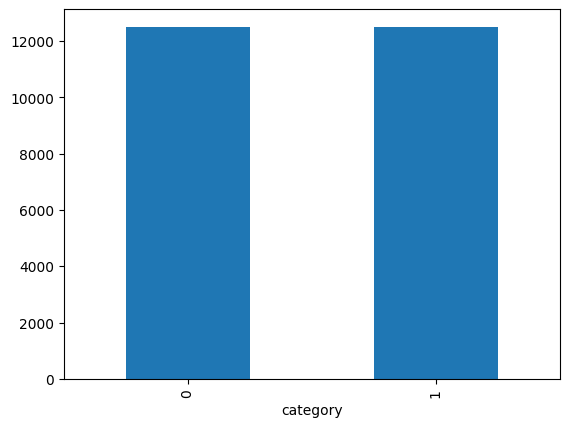

In [52]:
# visualize number of cats and dogs present in the dataframe
image_df['category'].value_counts().plot.bar()

## **3.1. Sample Image**

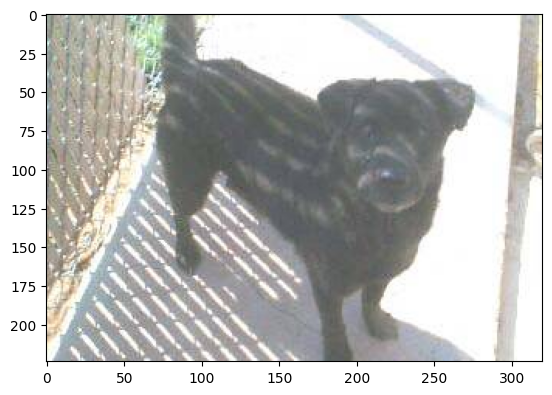

In [59]:
sample = random.choice(filenames)
image = load_img("/content/sample_data/train/train/"+sample)
plt.imshow(image)

# **4.Data Pre-processing**
As we use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding.

So we will convert 1 to "dog" and 0 to "cat"

In [60]:
# replace 0 as "cat" & 1 as "dog"
image_df["category"] = image_df["category"].replace({0: 'cat', 1: 'dog'})

In [61]:
# split the dataset for training & testing
train_df, validate_df = train_test_split(image_df, test_size=0.20, random_state=23)
# training dataset
train_df = train_df.reset_index(drop=True)
# testing dataset
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

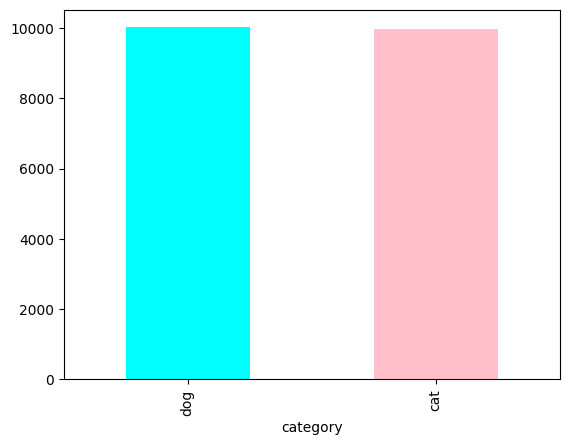

In [62]:
# see frequency of class variables in target column of training dataset
train_df['category'].value_counts().plot.bar(color=["cyan","pink"])

<Axes: xlabel='category'>

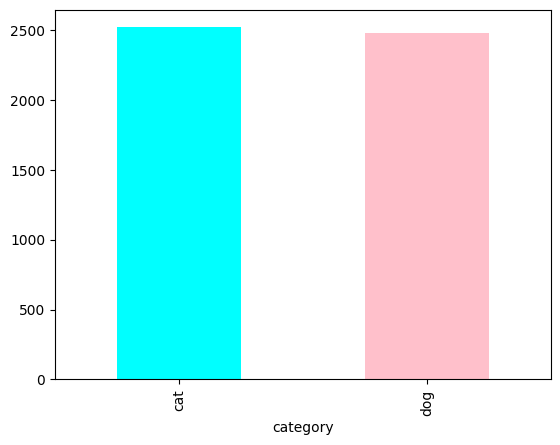

In [63]:
# see frequency of class variables in target column of testing dataset
validate_df['category'].value_counts().plot.bar(color=["cyan","pink"])

## **4.1. Define Constants**

In [64]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=15

In [65]:
train_df_size = train_df.shape[0]
validate_df_size = validate_df.shape[0]

## **4.2. Training Generator**

In [67]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/sample_data/train/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## **4.3. Validation Generator**

In [68]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/sample_data/train/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## **4.4. See how generator work**

In [69]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/sample_data/train/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


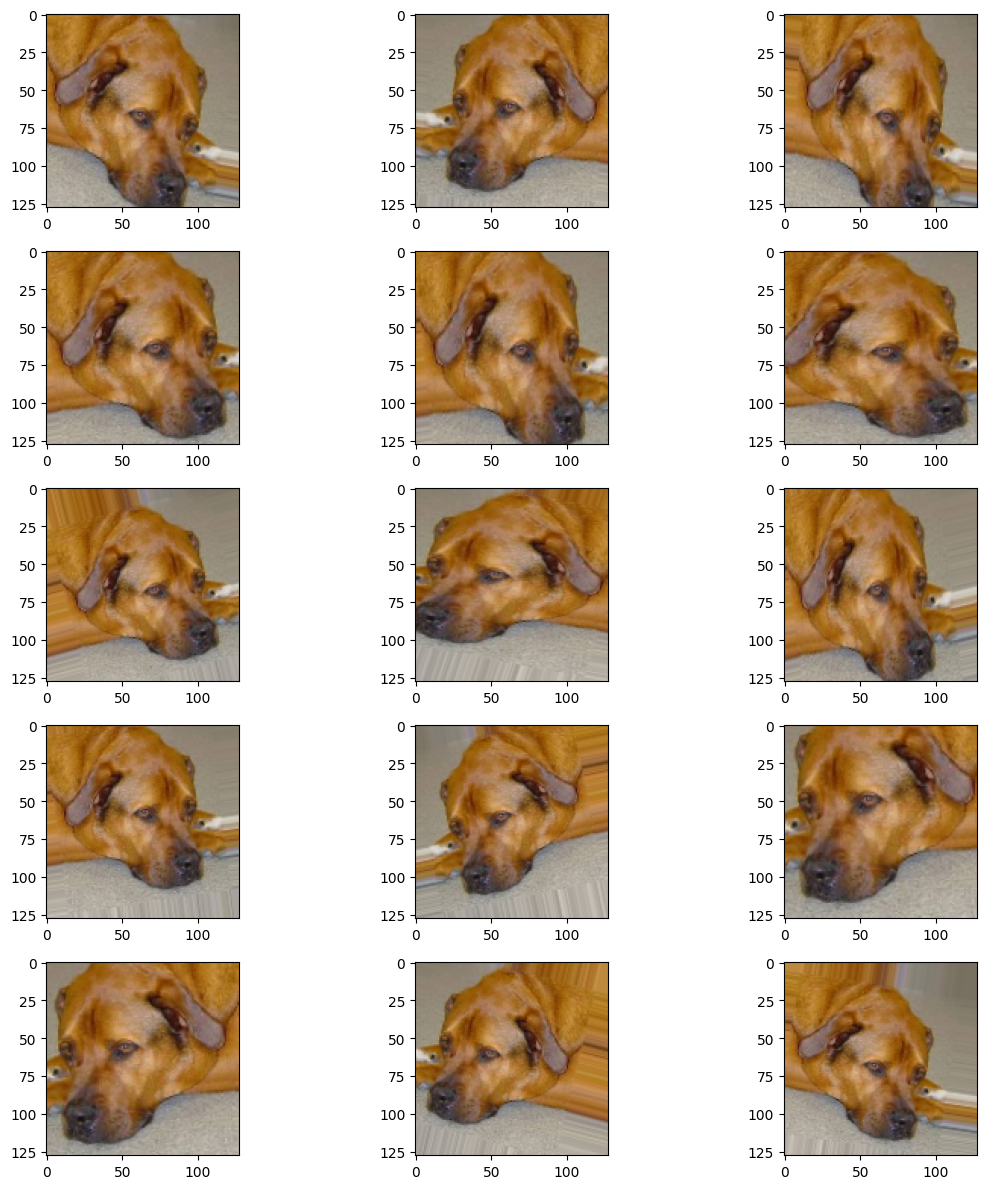

In [70]:
# visualize generated images from one image
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# **5. Model Building**
<img src="https://media.geeksforgeeks.org/wp-content/uploads/cat-vs-dog.jpg" width="100%"/>

* **Conv Layer**: Convolutional layers are the layers where filters are applied to the original image, or to other feature maps in a deep CNN.
* **Conv2D Layer**: Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
* **Pooling Layer**: Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.
* **BatchNormalization**: Layer that normalizes its inputs.Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

In [72]:
# Fungsi untuk membangun model dengan hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Convolution layer-1
    model.add(Conv2D(
        filters=hp.Int('filters_1', 16, 64, step=16),  # Jumlah filter: 16, 32, 48, 64
        kernel_size=hp.Choice('kernel_size_1', [3, 5]),  # Ukuran kernel: 3x3 atau 5x5
        activation='relu',
        input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))  # Dropout: 0.1 hingga 0.5

    # Convolution layer-2
    model.add(Conv2D(
        filters=hp.Int('filters_2', 32, 128, step=32),  # Jumlah filter: 32, 64, 96, 128
        kernel_size=hp.Choice('kernel_size_2', [3, 5]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    # Convolution layer-3
    model.add(Conv2D(
        filters=hp.Int('filters_3', 64, 256, step=64),  # Jumlah filter: 64, 128, 192, 256
        kernel_size=hp.Choice('kernel_size_3', [3, 5]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.1)))

    # Flattening layer
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units', 128, 512, step=128),  # Jumlah unit: 128, 256, 384, 512
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_4', 0.3, 0.6, step=0.1)))

    # Output layer
    model.add(Dense(2, activation='softmax'))  # 2 kelas: cat, dog

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')  # Learning rate: 0.0001 hingga 0.01
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Inisialisasi tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimalkan berdasarkan akurasi validasi
    max_trials=10,  # Coba 10 kombinasi hyperparameter
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cat_dog_tuning'
)

# Tampilkan ringkasan pencarian
tuner.search_space_summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Search space summary
Default search space size: 12
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernel_size_2 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
filters_3 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
kernel_size_3 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 

## **5.1. Callback Functions**
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.
- **EarlyStopping** : Used to avoid overfitting.Here we'll stop the training if there is no improvement in 3 conjecutive epochs.
- **ModelCheckpoint** : This callback saves the model after every epoch.The model'll save in a particular location with minimun 'val_loss'.
- **ReduceLROnPlateau** : It reduces learning rate when a metric has stopped improving.
For more about callback function click [here](https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html) [here](https://keras.io/api/callbacks/)

In [73]:
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/cd_model.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [74]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

In [75]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

## **5.2. Model Fitting**

In [ ]:
start_time = timer(None)
tuner.search(
    train_generator,
    epochs=3 if FAST_RUN else 20,  # Kurangi epoch untuk testing cepat, idealnya 20-40
    validation_data=validation_generator,
    validation_steps=validate_df_size//batch_size,
    steps_per_epoch=train_df_size//batch_size,
    callbacks=callbacks
)
timer(start_time)

Trial 1 Complete [00h 26m 18s]
val_accuracy: 0.872272253036499

Best val_accuracy So Far: 0.872272253036499
Total elapsed time: 00h 26m 18s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
64                |48                |filters_1
3                 |3                 |kernel_size_1
0.5               |0.3               |dropout_1
32                |96                |filters_2
3                 |3                 |kernel_size_2
0.3               |0.5               |dropout_2
256               |64                |filters_3
5                 |3                 |kernel_size_3
0.1               |0.4               |dropout_3
128               |128               |units
0.5               |0.4               |dropout_4
0.00011465        |0.00056492        |learning_rate

Epoch 1/20
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5757 - loss: 0.9462
Epoch 1: val_loss improved from inf to 1.28963, saving model to /content/sample_data/cd_model.h5


1333/1333 ━━━━━━━━━━━━━━━━━━━━ 133s 94ms/step - accuracy: 0.5757 - loss: 0.9462 - val_accuracy: 0.6202 - val_loss: 1.2896 - learning_rate: 1.1465e-04
Epoch 2/20
   1/1333 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.5333 - loss: 0.9599
Epoch 2: val_loss improved from 1.28963 to 1.24301, saving model to /content/sample_data/cd_model.h5


1333/1333 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5333 - loss: 0.9599 - val_accuracy: 0.6246 - val_loss: 1.2430 - learning_rate: 1.1465e-04
Epoch 3/20
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6438 - loss: 0.7176
Epoch 3: val_loss did not improve from 1.24301
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 142s 104ms/step - accuracy: 0.6438 - loss: 0.7176 - val_accuracy: 0.6286 - val_loss: 1.7197 - learning_rate: 1.1465e-04
Epoch 4/20
   1/1333 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.4667 - loss: 0.7864
Epoch 4: val_loss did not improve from 1.24301
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4667 - loss: 0.7864 - val_accuracy: 0.6322 - val_loss: 1.6913 - learning_rate: 1.1465e-04
Epoch 5/20
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6805 - loss: 0.6273
Epoch 5: val_loss did not improve from 1.24301
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 116s 87ms/step - accuracy: 0.6805 - loss: 0.6273 - val_accuracy: 0.5449 - val_loss: 8.1920 - learning_rate: 1.1465e

## **5.3. Save the Model**

In [ ]:
# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# Tampilkan ringkasan model terbaik
best_model.summary()

# Simpan model terbaik
best_model.save("cat_dog_classifier_tuned.h5")

## **5.4. Load Model**

In [ ]:
from keras.models import load_model
new_model = load_model('/content/cat_dog_classifier_tuned.h5')

## **5.5. Visualize training accuracy and loss**

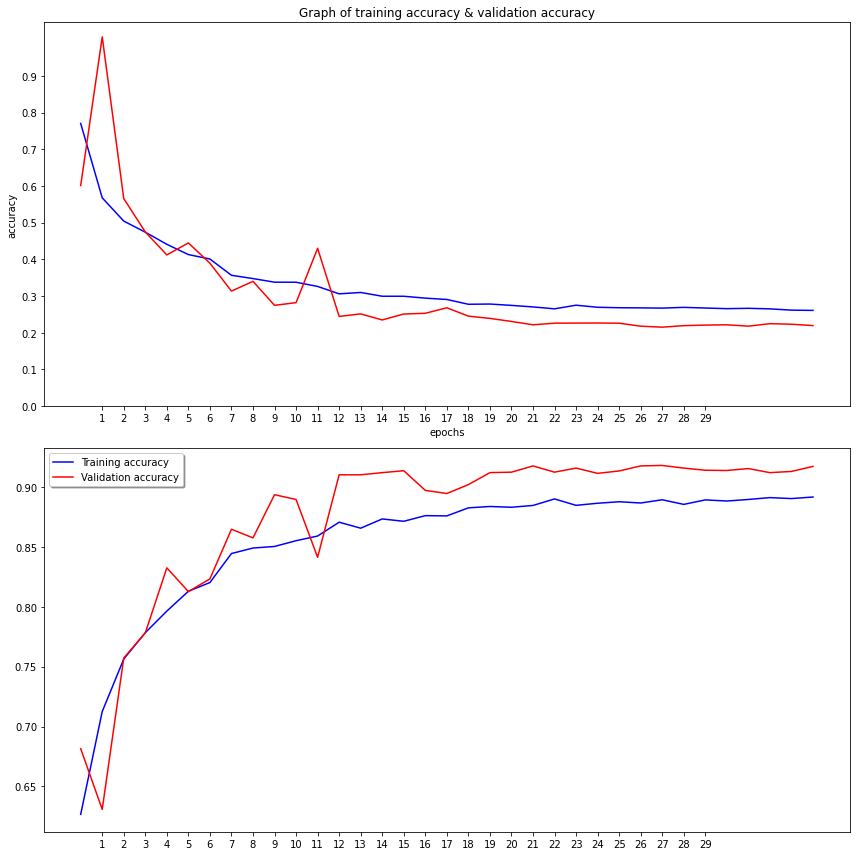

In [ ]:
# Latih ulang model terbaik untuk mendapatkan history (opsional)
history = best_model.fit(
    train_generator,
    epochs=3 if FAST_RUN else 20,
    validation_data=validation_generator,
    validation_steps=validate_df_size//batch_size,
    steps_per_epoch=train_df_size//batch_size,
    callbacks=callbacks
)

# Visualisasi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot training & validation loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()

# Plot training & validation accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_loss_tuned.png')
plt.show()

# **6. Prepare Testing Data**

In [ ]:
# unzip the dataset
from zipfile import ZipFile
zf = ZipFile('/content/test1.zip')
zf.extractall('/content/sample_data') #save files in selected folder
zf.close()

In [ ]:
# create a dataframe and store all image files
test_filenames = os.listdir("/content/sample_data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## **6.1. Create Testing Generator**

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/sample_data/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# **7. Find Prediction**

In [ ]:
# find prediction using predict_generator
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
# here "category" column store the index of higher predicted value
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
# here predicted value will replace by "cat" for 0 & "dog" for 1
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
# See predicted dataframe
test_df.head()

,filename,category
0,8596.jpg,dog
1,5040.jpg,dog
2,6315.jpg,dog
3,4292.jpg,cat
4,7065.jpg,dog


## **7.1. Visualize Result**

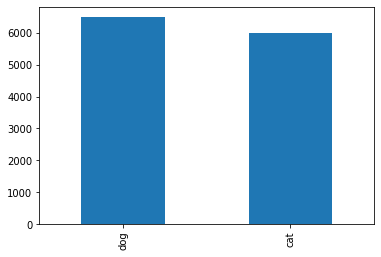

In [ ]:
# see how many images classify into which class
test_df['category'].value_counts().plot.bar()

## **7.2. See Predicted Image With Images**

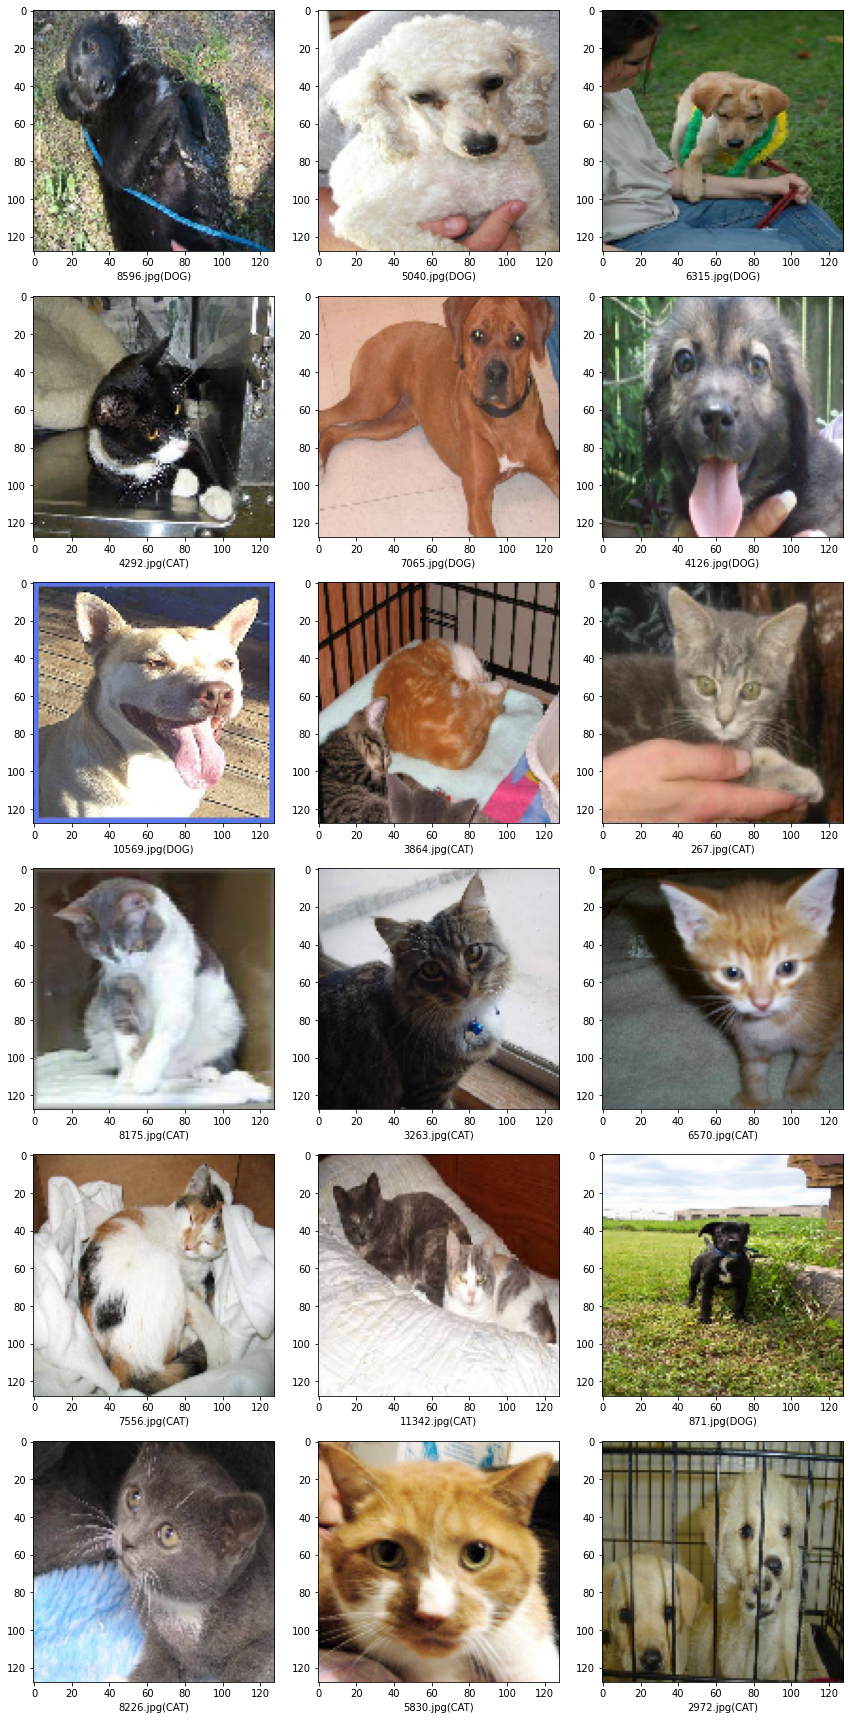

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/sample_data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category.upper()) + ')' )
plt.tight_layout()
plt.show()

If you get any issues during run this notebook.Feel free to contact.
[Linkedin](https://www.linkedin.com/in/sidharth178),
[Github](https://github.com/sidharth178)

Thank You.
